# “达观杯”文本智能处理挑战赛

## 数据

数据包含2个csv文件：

》train_set.csv：此数据集用于训练模型，每一行对应一篇文章。文章分别在“字”和“词”的级别上做了脱敏处理。共有四列：
第一列是文章的索引(id)，第二列是文章正文在“字”级别上的表示，即字符相隔正文(article)；第三列是在“词”级别上的表示，即词语相隔正文(word_seg)；第四列是这篇文章的标注(class)。
注：每一个数字对应一个“字”，或“词”，或“标点符号”。“字”的编号与“词”的编号是独立的！

》test_set.csv：此数据用于测试。数据格式同train_set.csv，但不包含class。
注：test_set与train_test中文章id的编号是独立的。

### 评分标准

评分算法
binary-classification
评分标准
采用各个品类F1指标的算术平均值，它是Precision 和 Recall 的调和平均数。

AB榜的划分方式和比例：
【1】评分采用AB榜形式，提交文件必须包含测试集中所有用户的预测值。排行榜显示A榜成绩，竞赛结束后2小时切换成B榜单。B榜成绩以选定的两次提交或者默认的最后两次提交的最高分为准，最终比赛成绩以B榜单为准。

【2】此题目的AB榜是随机划分，A榜数据占50%，B榜使用全量测试集，即占100%。

### 导入包

In [1]:
# 数据处理
import numpy as np
import pandas as pd

# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# 系统文件
import os


In [2]:
# 数据所在文件夹
os.listdir(r'C:\Users\10068899\OneDrive\sublime python\new_data')

['biliHelp.js',
 'data_grand.py',
 'hello.png',
 'hive.sql',
 'logsit.py',
 'manifold learning.py',
 'stockTickers.py',
 'test_set.csv',
 'train_set.csv']

### 导入数据

In [3]:
# 导入训练集
train_data = pd.read_csv(r'C:\Users\10068899\OneDrive\sublime python\new_data\train_set.csv')
print("train_data.shape:",train_data.shape)
train_data.head()

train_data.shape: (102277, 4)


,id,article,word_seg,class
0,0,7368 1252069 365865 755561 1044285 129532 1053...,816903 597526 520477 1179558 1033823 758724 63...,14
1,1,581131 165432 7368 957317 1197553 570900 33659...,90540 816903 441039 816903 569138 816903 10343...,3
2,2,7368 87936 40494 490286 856005 641588 145611 1...,816903 1012629 957974 1033823 328210 947200 65...,12
3,3,299237 760651 299237 887082 159592 556634 7489...,563568 1239563 680125 780219 782805 1033823 19...,13
4,4,7368 7368 7368 865510 7368 396966 995243 37685...,816903 816903 816903 139132 816903 312320 1103...,12


训练集共有102277条数据，包括预测的类别共有4个特征。

In [4]:
# 导入测试集
test_data = pd.read_csv(r'C:\Users\10068899\OneDrive\sublime python\new_data\test_set.csv')
print("test_data.shape:",test_data.shape)
test_data.head()

test_data.shape: (102277, 3)


,id,article,word_seg
0,0,7368 146447 316564 42610 55736 297797 93042 53...,816903 565958 726082 764656 335008 75094 20282...
1,1,985531 473628 1044285 1121849 206763 462208 11...,729468 520477 529032 101368 335130 520477 1113...
2,2,7368 7368 7368 7368 7368 7368 7368 7368 7368 7...,816903 816903 816903 816903 816903 816903 8169...
3,3,529819 1226459 856005 1177293 663773 272235 93...,231664 1033823 524850 330478 507199 520477 618...
4,4,42610 1252069 1077049 955883 1125260 1044285 2...,545370 379223 162767 520477 1194630 1197475 11...


测试集和训练集相似，但没有“class”这个字段。

### EDA

一. 检查目标列的分布

In [5]:
train_data['class'].value_counts()

3     8313
13    7907
9     7675
15    7511
18    7066
8     6972
6     6888
14    6740
19    5524
1     5375
12    5326
10    4963
4     3824
11    3571
16    3220
17    3094
7     3038
2     2901
5     2369
Name: class, dtype: int64

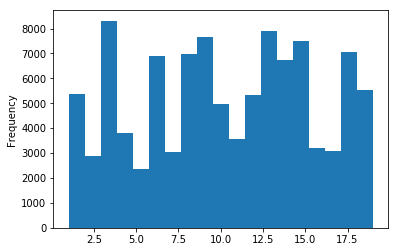

In [6]:
train_data['class'].astype(int).plot.hist(bins = 19)

由上图可知，这是一个不平衡的多分类问题（imbalance class problem）,解决方法包括基于采样方法和基于cost function的方法。本文将采用SMOTE过采样方法。

二. 检查缺失值（missing value）

In [7]:
# 基于列统计数据中的null值
def missing_value_table(df):
    # 总的缺失值的个数
    miss_value = df.isnull().sum()
    
    # 缺失值占总数的百分比
    miss_value_per = miss_value*100/len(df)
    
    # 为缺失值建立一个表格
    print("miss_value:", miss_value)
    print("miss_value_percent:" , miss_value_per, "%")
    
print("train data missing value：")
missing_value_table(train_data)

print("test data missing value:")
missing_value_table(test_data)

train data missing value：
miss_value: id          0
article     0
word_seg    0
class       0
dtype: int64
miss_value_percent: id          0.0
article     0.0
word_seg    0.0
class       0.0
dtype: float64 %
test data missing value:
miss_value: id          0
article     0
word_seg    0
dtype: int64
miss_value_percent: id          0.0
article     0.0
word_seg    0.0
dtype: float64 %


我们的表格很干净，并不存在缺失值。

三。 列的类型

In [8]:
train_data.dtypes

id           int64
article     object
word_seg    object
class        int64
dtype: object

### 特征工程（feature engineering）

对于文本字段，我们采用TF-IDF指标来表征文本。表格中有字和词两类特征，我们先使用词特征来作为模型的输入特征。

In [9]:
# 导入TfidfVectorizer类
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X_word_seg_train = vec.fit_transform(train_data['word_seg'])
X_word_seg_train.shape

(102277, 875122)

使用SVD方法进行降维

In [10]:
#
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X_word_seg_train)

X.shape

(102277, 100)

相关系数

Text(0.5,1,'Correlation Heatmap')

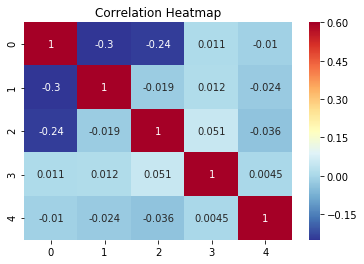

In [11]:
target = train_data['class']
data = pd.DataFrame(X[:,:5])
data_corr = data.corr()
data_corr

# Heatmap of correlations
sns.heatmap(data_corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

### Baseline Model

使用线性svc分类

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = train_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

clfs = [SVC(),
       RandomForestClassifier(n_estimators = 500),
       GaussianNB()]

f1_score_dic = {}
for clf in clfs:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    score = f1_score( y_test, predicted, average=None)
    f1_score_dic[name] = score
#     mat = confusion_matrix(y_test, predicted)
#     print(name+" confusion_matrix:")
#     sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,)
#     plt.xlabel('true label')
#     plt.ylabel('predicted label');
    
print(f1_score_dic)

{'SVC': array([0.47162023, 0.53286385, 0.60634495, 0.70119522, 0.68758916,
       0.84705882, 0.52989691, 0.62724127, 0.83344051, 0.59247136,
       0.50975456, 0.49074564, 0.65457788, 0.68466597, 0.78069175,
       0.35281837, 0.52723312, 0.71630537, 0.38247619]), 'RandomForestClassifier': array([0.54959514, 0.68405797, 0.76303855, 0.761347  , 0.75555556,
       0.87004813, 0.62171629, 0.65637542, 0.87310898, 0.62210526,
       0.59807074, 0.57491459, 0.70123748, 0.73711531, 0.86000691,
       0.53553038, 0.64711274, 0.78318438, 0.49021277]), 'GaussianNB': array([0.39228296, 0.52269171, 0.5800738 , 0.67355982, 0.75222363,
       0.75315169, 0.52830189, 0.5145287 , 0.77079677, 0.49429224,
       0.38117647, 0.392296  , 0.5331943 , 0.63272411, 0.74343122,
       0.308     , 0.57692308, 0.59948762, 0.27709943])}


In [31]:
for k in f1_score_dic:
    print(k, np.mean(f1_score_dic[k]))

SVC 0.606789007333564
RandomForestClassifier 0.6886491371134783
GaussianNB 0.5487492328202078
